In [1]:
from  src.dataloader import *
from src.bdappv import *
from src.metrics import *
from src.resnet18 import *
from src.confusion_matrix import make_confusion_matrix
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn as nn
import tensorflow as tf
from sklearn.metrics import fbeta_score, make_scorer, f1_score, accuracy_score, recall_score, precision_score, fbeta_score, precision_recall_curve, auc, roc_curve, log_loss, confusion_matrix
import torchvision.models as models
import os
from src.tsne import *
from torch.utils.data import DataLoader
import matplotlib
import torchvision.models as models
from sklearn.manifold import TSNE
import math

c:\Users\yanis\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] La procédure spécifiée est introuvable
  warn(f"Failed to load image Python extension: {e}")


In [2]:
dataset=BDAPPVClassification(img_dir="C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google3", size=None)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

716
torch.Size([32, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)


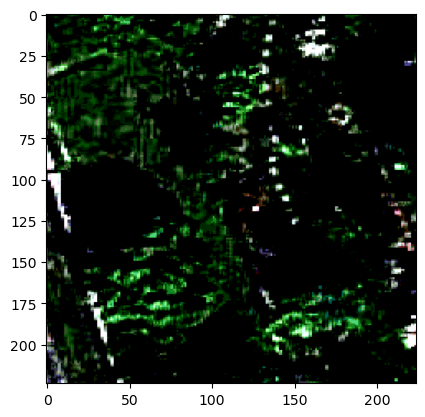

In [3]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

dataset_crop=BDAPPVClassification(img_dir="C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google3",
                                  size=224,
                                  transform=transforms.Compose([transforms.Normalize(mean = [0.346024751663208, 0.35355815291404724, 0.3038492202758789],
                                                                    std= [0.20496879518032074, 0.18832367658615112, 0.18234187364578247])]))
# Define the indices for training and testing sets
n = len(dataset)
train_size = int(0.8 * n)
test_size = n - train_size
train_indices = torch.arange(0, train_size)
test_indices = torch.arange(train_size, n)

# Define the samplers for training and testing sets
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Define the dataloaders for training and testing sets
train_dataloader_augmente = DataLoader(dataset_crop, batch_size=32, sampler=train_sampler)
test_dataloader_augmente = DataLoader(dataset_crop, batch_size=32, sampler=test_sampler)

print(len(train_dataloader_augmente))
batch = next(iter(train_dataloader_augmente))
print(batch[0].shape)
plt.imshow(batch[0][0].permute(1, 2, 0))
print(batch[1][0])

In [6]:
def sig(x):
    return 1/(1 + np.exp(-x))

def predict(model, path_model, valid_loader, device=None):
    """Pour prédire 0/1 à partir de l'échantillon de validation
       /!\ certains commentaires sont à passer en code pour passer sur GPU

    """
    model.load_state_dict(torch.load(path_model))
    model.eval()

    array_labels=np.array([])
    array_preds=np.array([])
    probas_pred=np.array([])

    for data,label in valid_loader:
        # Pour utiliser GPU

        # inputs = inputs.to(device)
        # labels = labels.to(device)
        # model.to(device)

        with torch.no_grad():
            output = model(data)
        output_detach = output.detach()

        # calculate the loss
        preds=torch.zeros(output_detach.shape[0], output_detach.shape[1])
        probas=torch.zeros(output_detach.shape[0], output_detach.shape[1])

        for i in range(len(output_detach)):
            if sig(output_detach[i])>0.5:
                preds[i]=1
            else: preds[i]=0
            probas[i]=sig(output_detach[i])
        probas_pred=np.append(probas_pred, probas.T.numpy()[0])
        array_preds=np.append(array_preds,preds.T.numpy()[0])
        array_labels=np.append(array_labels, label.numpy())

    return array_labels, array_preds, probas_pred

In [24]:
def predict2(model, path_model, valid_loader, device=None):
    """Pour prédire 0/1 à partir de l'échantillon de validation
       /!\ certains commentaires sont à passer en code pour passer sur GPU
    """

    model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu')))
    model.eval()

    array_labels=np.array([])
    array_preds=np.array([])
    probas_pred=np.array([])

    for data,label in valid_loader:
        # Pour utiliser GPU

        with torch.no_grad():
            output = model(data)
        output_detach = output.detach()  # Move to CPU and detach from GPU

        # calculate the loss
        preds=torch.zeros(output_detach.shape[0], output_detach.shape[1])
        probas=torch.zeros(output_detach.shape[0], output_detach.shape[1])

        for i in range(len(output_detach)):
            if sig(output_detach[i])>0.5:
                preds[i]=1
            else:
                preds[i]=0
            probas[i] = sig(output_detach[i])
        probas_pred=np.append(probas_pred, probas.T.numpy()[0])
        array_preds=np.append(array_preds,preds.T.numpy()[0])
        array_labels=np.append(array_labels, label.numpy())  # Move to CPU and convert to numpy

    return array_labels, array_preds, probas_pred

In [11]:
resnet18_1 = models.resnet18(pretrained=True)
resnet18_2 = models.resnet18(pretrained=True)

In [15]:

#Furthermore, in feature extracting, we don't need to calculate gradient for any layers except 
# the last layer that we initialize. For this we need to set .requires_grad to False
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18_1)


nr_filters = resnet18_1.fc.in_features  #number of input features of last layer
#On ne met pas de sigmoid dans la dernière couche. C'est composé par la loss BCEWithLogitsLoss qui applique une sigmoid afin de calculer la cross-enthropy
resnet18_1.fc = nn.Linear(nr_filters, 1)

In [13]:
nr_filters = resnet18_2.fc.in_features  #number of input features of last layer
#On ne met pas de sigmoid dans la dernière couche. C'est composé par la loss BCEWithLogitsLoss qui applique une sigmoid afin de calculer la cross-enthropy
resnet18_2.fc = nn.Linear(nr_filters, 1)

resnet18_2.layer1.append(nn.Dropout(0.1))
resnet18_2.layer2.append(nn.Dropout(0.6))
resnet18_2.layer3.append(nn.Dropout(0.3))
resnet18_2.layer4.append(nn.Dropout(0.8))

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [17]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

y_true_train, y_pred_train, proba_pred_train=predict(model=resnet18_1, path_model="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/trained_resnet18_autocrop_30epochs.pth", valid_loader=train_dataloader_augmente, device=None)
y_true_val, y_pred_val, proba_pred_val=predict(model=resnet18_1, path_model="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/trained_resnet18_autocrop_30epochs.pth", valid_loader=test_dataloader_augmente, device=None)

In [25]:
y_true_train2, y_pred_train2, proba_pred_train2=predict2(model=resnet18_2, path_model="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/trained_resnet18_cloud.pth", valid_loader=train_dataloader_augmente, device=None)
y_true_val2, y_pred_val2, proba_pred_val2=predict2(model=resnet18_2, path_model="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/trained_resnet18_cloud.pth", valid_loader=test_dataloader_augmente, device=None)

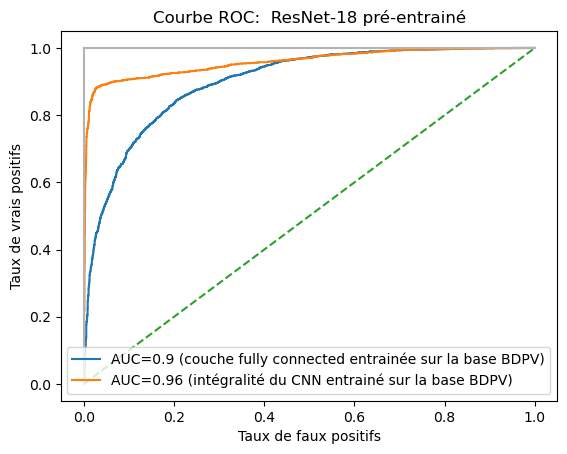

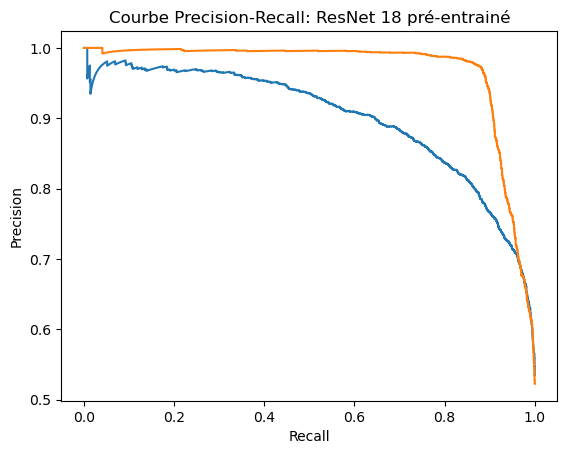

In [29]:
FP_rate_1, TP_rate_1, thresholds_keras_1 = roc_curve(y_true_val, proba_pred_val)
AUC_1= auc(FP_rate_1, TP_rate_1)

FP_rate_2, TP_rate_2, thresholds_keras_2 = roc_curve(y_true_val2, proba_pred_val2)
AUC_2= auc(FP_rate_2, TP_rate_2)

plt.title('Courbe ROC:  ResNet-18 pré-entrainé')
plt.plot(FP_rate_1, TP_rate_1, label="AUC="+str(round(AUC_1, 2))+" (couche fully connected entrainée sur la base BDPV)")
plt.plot(FP_rate_2, TP_rate_2, label="AUC="+str(round(AUC_2, 2))+" (intégralité du CNN entrainé sur la base BDPV)")

plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.savefig('ROC_final.png')
plt.show()

prec1, rec1, thresholds_keras1 = precision_recall_curve(y_true_val, proba_pred_val)
prec2, rec2, thresholds_keras2 = precision_recall_curve(y_true_val2, proba_pred_val2)

fig, ax = plt.subplots()
ax.plot(rec1, prec1, label="Couche fully connected entrainée sur la base BDPV")
ax.plot(rec2, prec2, label="Intégralité du CNN entrainé sur la base BDPV")

#add axis labels to plot
ax.set_title('Courbe Precision-Recall: ResNet 18 pré-entrainé')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.savefig('prec_recall_final.png')
plt.show()
